# Разбор статьи "A Unified Theory of Decentralized SGD with Changing Topology and Local Updates"

# Постановка задачи

## Стохастический градиентный спуск

При больших потоках данных возникает проблема их обработки. На помощь приходит улучшение классического градиентного спуска - _стохастический градиентный спуск_. Оно эффективно, когда в выборке много данных или требуется оценить большое количество параметров. В классической реализации градиентного спуска количество вычислений можно примерно оценить, как $(\text{# of gradients}) \cdot (\text{# of data points}) \cdot (\text{# of iterations})$

В стохастическом градиентном спуске на каждом шаге вместо, например, всего тренировочного датасета, берется одно значение. В этом случае можно оценить количество вычислений, как $(\text{# of gradients}) \cdot (\text{# of iterations})$

## Задача стохастической оптимизации

Пусть $\mathcal{X}$ - пространство параметров, случайная величина $\xi$ - случайное значение полученное из $\mathcal{X}$, $f(x, \xi)$ - функция потерь, $\mathcal{D}_i$ - распределение данных, $\xi_i$ - элемент выборки. Тогда задача будет выглядеть следующим образом:

$$f^* := \min_{x \in \mathbf{R}^d} \left[ f(x) := \mathbb{E}_{\xi\sim \mathcal{D}} [f(x, \xi)] \right]$$




На практике же, в качестве выборки используют не единственную точку, а некое подмножество точек (mini-batch).

Тогда шаг SGD выглядит следующим образом:

$$\text{Shuffle sample, randomly choose j, $n$ - batch size}$$

$$x_{k+1} = x_k - \gamma_k \nabla{F(x_k, \xi^{j:j+n})}$$

---

## Параллельные методы оптимизации

Помимо этого, еще одной идеей улучшения классического градиентного спуска - распределение вычислений между несколькими устройствами. Локально устройства запускают методы, затем спустя несколько итераций происходит общение между устройствами. Так, жизнь метода выглядит следующим образом: локально устройства вычисляют градиенты/оценки параметров, после некоторых итераций происходит передача сообщений (оценок параметров) между устройствами и так далее. В алгоритме ниже обмен сообщениями будет осуществляться через _gossip averaging_.

---

Объединяя данные две идеи, получаем метод Decentralized SGD. В работе уделяется внимание созданию обобщенного фреймворка для реализации Decentralized SGD на произвольных топологиях.

## Идея статьи

### Задача распределенной стохастической оптимизации

$$f^* := \min_{x \in \mathbf{R}^d} \left[ f(x) := \frac{1}{n} \sum_{i=1}^{n}f_i(x) \right]$$

где компоненты $f_i: \mathbb{R}^d \to \mathbb{R}$ распределены между $n$ вершинами и даны в стохастической форме:

$$f_i(x) := \mathbb{E}_{\xi_i \sim \mathcal{D}_i} F_i(x, \xi_i)$$

где $\mathcal{D}_i$ - распределение данных, $\xi_i$ - элемент выборки над пространством параметров $\mathcal{X}_i$ в вершине $i$.

Важным частным случаем этой задачи является стандартная минимизация эмпирического риска. В этом случае
$\mathcal{D}_i$ содержит конечное $m_i$ число элементов $\{\xi_i^1, \dots, \xi_i^{m_i} \}$. Тогда условия на компоненты можно переписать следующим образом:

$$f_i(x) = \frac{1}{m_i} \sum_{j=1}^{m_i} F_i(x, \xi_i^j)$$

Далее будем пользоваться следующими обозначениями:

<h5><center>$x_i^{(t)}$ - результат вычислений при вершине $i$ на $t$-ом шаге</center></h5>

$$\overline{x}^{(t)} := \frac{1}{n} \sum_{i=1}^{n} x_i^{(t)}$$

$$X^{(t)} := \left[x_1^{(t)}, \dots, x_n^{(t)}\right] \in \mathbb{R}^{d \times n}$$

$$\overline{X}^{(t)} := \left[ \overline{x}^{(t)}, \dots, \overline{x}^{(t)} \right] = X^{(t)}\frac{1}{n} \mathbf{1} \mathbf{1}^T$$

$$\partial{F(X^{(t)}, \xi^{(t)})} := \left[ \nabla{F_1(x_1^{(t)}, \xi_1^{(t)})}, \dots, \nabla{F_n(x_n^{(t)}, \xi_n^{(t)})} \right] \in \mathbb{R}^{d \times n}$$

### Gossip averaging


Рассмотрим граф сети, где вершины - устройства, а соединенные устройства имеют ребро между собой. Тогда обмен сообщениями реализуется усреднением слухов (_gossip averaging_). Его принцип имитирует процесс распространения сплетней (или же диффузии в природе). При общении, соседние узлы делятся своими локальными оценками, усредняя их со значениями, полученных от соседей (усреднение может быть взвешенное). Таким образом, устройства вычисляют приблизиженно централизованный результат.

Смешивающей матрицей (_mixing matrix_) называется симметричная, дважды стохастическая $(W \mathbf{1} = \mathbf{1} ,\, \mathbf{1}^T W = \mathbf{1})$ матрица $W \in [0, 1]^{n \times n}$

Более формально, _gossip averaging_ выглядит следующим образом:


$$x_i^{(t+1)} = \displaystyle \sum_{j=0}^n w_{ij}^{(t)}x_j^{(t)} \Leftrightarrow X^{(t+1)} = X^{(t)}W^{(t)},$$

т.е., $w_{ij} > 0 \Leftrightarrow$ устройства $i$ и $j$ являются соседями

Примеры топологий - звезда, кольцо, $2d$-тор, полный граф

Примеры весов:

1. (Одна степень вершин - True среднее) $w_{ij} = \frac{1}{deg_i + 1}$

2. (Разные степени вершин - Metropolis-Hastings) $w_{ij} = \frac{1}{\max(deg_i, deg_j) + 1}$

Однако не каждая смешивающая матрица подходит для нашей задачи. Нужно предположить, что смешивающая матрица действительно усредняет, т. е. спустя $\tau$ усредняющих шагов композиция матриц приближает значения матрицы $X$ к $\overline{X}.$

### Алгоритм Decentralized SGD

**Input:** $X^{(0)}$, размеры шагов $\{\gamma_i\}$, множество смешивающих матриц $W^{(t)} \sim \mathcal{W}^{(t)}$

**Step:**

$$X^{(t+\frac{1}{2})} := X^{(t)} - \gamma_t \partial{F(X^{(t)}, \xi^{(t)})}$$

$$X^{(t+1)} := X^{(t+\frac{1}{2})}W^{(t)}$$

**Output:** $\overline{x}^{(T)}$

---

## Общий фреймворк Decentralized SGD

Довольно понятно, что данный фрейморк является довольно обобщенным, потому что, до тех пор, пока объекты удовлетворяют предположениям, выбор протокола _gossip average_ произвольный, т. е. можно контролировать частоту обмена сообщениями, топологию сети устройств, веса средних. Так, данный фреймворк покрывает различные идеи реализации SGD:

1. _Centralized mini-batch SGD_ - устройства на собственных датасетах вычисляют градиенты, обмен градиентами происходит через сервер(или отдельную вершину), сервер отправляет полученный результат обратно устройствам. (Полный граф $W = \frac{1}{n} \mathbf{1} \mathbf{1}^T)$

2. _Loopless local SGD_ - на каждом шаге берется смешивающая матрица $W$ с вероятностью $\frac{1}{\tau}$ и $\mathbf{I}_n$ с вероятностью $1-\frac{1}{\tau}$ для некоторого параметра $\tau \geq 1$

3. _Local SGD_ - усреднение просиходит через каждые фиксированное $\tau$ шагов. В остальных шагах происходит только локальное вычисление. (Для таких $\tau - 1$ шагов берем смешивающую матрицу $W = \mathbf{I}_n$). Заметим, что при усреднении можно выбрать произвольную смешивающую матрицу, тогда мы получим _random decentralized local SGD_.

4. _Periodic decentralized SGD_ - множественные локальные вычисления и шаги усреднения (при некотором фиксированном $W$) повторяются периодически.

pairwise parametrized gossip???

linear convergence for overparamentrized regime?

Вывод???

# Теоретические выкладки

## Предположения
Для работы алгоритма и следующих теоретических выкладок, нам могут пригодиться следующие предположения:

### $L$-гладкость $f$

1.1) $\forall i \in [n] \, F_i(X, \xi) : \mathbb{R}^d \times \Omega_i \to \mathbb{R}$ - дифференцируемая $\forall \xi \in supp(\mathcal{D_i})$, а также $\exists L \geq 0: \forall x, y \in \mathbb{R}^d, \xi \in supp(\mathcal{D}_i):$

$$\|\nabla{F_i(y, \xi)} - \nabla{F_i(x, \xi)} \| \leq L \| x - y \|$$

В некоторых случаях достаточно предположить $L$-гладкость функций $f_i$

1.2) $\forall i \in [n] \, f_i : \mathbb{R}^d \to \mathbb{R}$ - дифференцируема, а также $\exists L \geq 0 \, \forall x, y \in \mathbb{R}^d:$

$$\| \nabla{f_i(y)} - \nabla{f_i(x)} \| \leq L \| x - y \|$$

---

### $\mu$-выпуклость $f_i$

2) $\forall i \in [n] \, f_i: \mathbb{R}^d \to \mathbb{R}$ является $\mu$-выпуклой для $\mu \geq 0$. Другими словами, $\forall x, y \in \mathbb{R}^d:$

$$f_i(x) - f_i(y) + \frac{\mu}{2}\| x - y \|_2^2 \leq \langle \nabla{f_i(x)} ,\, x - y \rangle$$

---

### Ограниченность шума на оптимальном значении $x^*$
Чтобы выразить, насколько разнообразны функции $f_i$ в выпуклом случае достаточно измерить ее только в оптимальных точках (в строго выпуклых функциях такая точка обязательно найдется):

3.1) Пусть $\displaystyle x^* = \mathop{\arg\min}_{x \in \mathbb{R}^d} f_i(x)$, также определим:

$$\zeta_i^2 := \|\nabla{f_i(X^*)}\|_2^2, \qquad \overline{\zeta}^2 := \frac{1}{n} \sum_{i=1}^n \zeta_i^2$$

$$\sigma_i^2 := \mathbb{E}_{\xi_i} \| \nabla{F_i(x^*, \xi_i)} - \nabla{f_i(x^*)} \|_2^2, \qquad \overline{\sigma}^2 := \frac{1}{n} \sum_{i=1}^n \sigma_i^2$$

Предполагаем, что $\overline{\sigma}^2, \overline{\zeta}^2$ ограничены.

Здесь, $\overline{\sigma}^2$ - является показателем уровня шума, $\overline{\zeta}^2$ - разнообразия фукнций $f_i$.

Для невыпуклых задач необязательно существует единственная $x^*$, поэтому ослабим ограничение:

3.2) $\exists P, \hat{\zeta}$ такие, что $\forall x \in \mathbb{R}^d:$

$$\frac{1}{n} \sum_{i=1}^n \| \nabla{f_i(x)} \|_2^2 \leq \hat{\zeta}^2 + P \| \nabla{f(x)} \|_2^2.$$

Помимо этого, $\exists M, \hat{\sigma}$ такие, что $\forall x_1, \dots, x_n \in \mathbb{R}^d:$

$$\Psi \leq \hat{\sigma}^2 + \frac{M}{n} \sum_{i=1}^n \| \nabla{f(x_i)} \|_2^2,$$
где $\Psi := \frac{1}{n} \sum_{i=1}^n \mathbb{E}_{\xi_i} \| \nabla{F_i(x_i, \xi_i)} - \nabla{f_i(x_i)} \|_2^2.$

---

### Ожидаемая степень согласованности (о смешивающей матрице)

4) $\exists p \in (0, 1] ,\, \tau \geq 1$ такие, что $ \forall X \in \mathbb{R}^{d \times n} ,\, \forall l \in \{ 0, \dots, \frac{T}{\tau} \}:$

$$\mathbb{E}_W \| XW_{l, \tau} - \overline{X} \|_F^2 \leq (1-p) \| X - \overline{X} \|_F^2,$$

где $W_{l, \tau} = W^{((l+1)\tau - 1)} \dots W^{(l\tau)} ,\, \overline{X} := X \frac{\mathbf{1}\mathbf{1}^T}{n}$ и $\mathbb{E}$ берется над распределениями $W^{(t)} \sim \mathcal{W}^{(t)}$ с индексами $t \in \{ l\tau, \dots, (l+1)\tau - 1 \}.$

---

## Сходимость метода

Под этими предположениями мы можем сделать выводы о верхней и нижней границе числа итерации

### Верхняя граница, невыпуклый случай

Используя предположения 1.2, 3.2, ошибка $\displaystyle\frac{1}{T+1} \sum_{t=0}^T \mathbb{E} \| \nabla{f(\overline{x}^{(t)})} \|_2^2 \leq \varepsilon$ достигается итераций:

$$\mathcal{O} \left( \frac{\hat{\sigma}^2}{n\varepsilon^2} + \frac{\hat{\zeta}\tau\sqrt{M+1} + \hat{\sigma}\sqrt{p\tau}}{p\varepsilon^{3/2}} + \frac{\tau\sqrt{(P+1)(M+1)}}{p\varepsilon} \right) \cdot LF_0$$

### Верхняя граница, выпуклый случай

Используя предположения 1.1, 3.1, ошибка $\displaystyle \frac{1}{T+1} \sum_{t=0}^T(\mathbb{E}f(\overline{x}^{(t)}) - f^*) \leq \varepsilon$ достигается после итераций:

$$\mathcal{O} \left( \frac{\hat{\sigma}^2}{n\varepsilon^2} + \frac{\sqrt{L}(\overline{\zeta}\tau + \overline{\sigma}\sqrt{p\tau}}{p\varepsilon^{3/2}} + \frac{L\tau}{p\varepsilon} \right) \cdot R_0^2$$

### Верхняя граница, сильно выпуклый случай

Используя предположения 1.1, 3.1, 2, для $\mu \geq 0$ ошибка $\displaystyle \frac{1}{T+1} \sum_{t=0}^T \frac{w_t}{W_T}(\mathbb{E}f(\overline{x}^{(t)}) - f^*)  + \mu \mathbb{E} \| \overline{x}^{(T+1)} - x^* \|^2 \leq \varepsilon$ достигается после итераций:

$$\tilde{\mathcal{O}} \left( \frac{\overline{\sigma}^2}{\mu n\varepsilon^2} + \frac{\sqrt{L}(\overline{\zeta}\tau + \overline{\sigma}\sqrt{p\tau})}{\mu p\sqrt{\varepsilon}} + \frac{L\tau}{\mu p} \log{\frac{1}{\varepsilon}} \right),$$

для положительных $w_t ,\, F_0 := f(x_0) - f^* ,\, R_0 = \| x_0 - x^* \|$ обозначают изначальные ошибки

### Нижняя граница, сильно выпуклый случай

Пусть существеют сильно выпуклые и гладкие $f_i: \mathbb{R}^d \to \mathbb{R} ,\, i \in [n],$ с условием, что $L = \mu = 1$, без стохастического шума $(\overline{\sigma}^2 = 0)$ такие, что алгоритм для любой смешивающей матрицы $W^{(t)} \sim W$ при $p<1$  для $\tau=1$ требует как минимум

$$T = \tilde{\Omega} \left( \frac{\overline{\zeta}(1-p)}{\sqrt{\varepsilon}p} \right)$$

итерации для сходимости до точности $\varepsilon$

Можно показать, что условия, поставленные на $\overline{\zeta}$ являются необходимыми в сильно выпуклом случае и оценка не может быть улучшена

---

## Идея доказательств

### Верхняя оценка, сильно выпуклый случай

Лемма 1: С предположениями 1.1, 2, 3.1, 4 $\overline{x}^{(t)}$ в итерациях алгоритма с шагом $\eta_t \leq \frac{1}{12L}$ удовлетворяют:

$$\mathbb{E}_{\xi_1^{(t)}, \cdots, \xi_n^{(t)}} \| \overline{x}^{(t+1)} - x^* \|^2 \leq \left( 1-\frac{\eta_t \mu}{2} \right) \| \overline{x}^{(t)} - x^* \|^2 + \frac{\eta_t^2 \overline{\sigma}^2}{n} - \eta_t \left( f(\overline(x)^{(t)} - f^* \right) + \eta_t \frac{3L}{n} \sum_{i=1}^n \| \overline{x}^{(t)} - x_i^{(t)} \|^2$$

Лемма 2: C предположениями 1.1, 2, 3.1, 4, если $F_i$ являются выпуклыми и шаги $\eta_t \leq \frac{p}{96\sqrt{3} \tau L}, тогда:$

$$\Xi_t \leq \left(1 - \frac{p}{2} \right) \Xi_{m\tau} + \frac{p}{16\tau} \sum_{i=m\tau}^{t-1} \Xi_j + 36L \frac{\tau}{p} \sum_{j=m\tau}^{t-1} \eta_j^2 (f(\overline{x}^{(j)} - f(x^*)) + \left( \overline{\sigma}^2 + \frac{18\tau}{p} \overline{\zeta}^2 \right) \sum_{j=m\tau}^{t-1} \eta_j^2,$$

где $\Xi_t = \frac{1}{n} \mathbb{E}_t \sum_{i=1}^n \| x_i^{(t)} - \overline{x}^{(t)} \|^2$ - согласованное расстояние, $m = \lfloor \frac{t}{\tau} \rfloor - 1.$


### Нижняя оценка, сильно выпуклый случай

$$x^{(t+1)} = Wx^{(t+\frac{1}{2})} = W((1-\eta)x^{(t)} + \eta y)$$

In [ ]:
import matplotlib.pyplot as plt
import autograd as ad
import autograd.numpy as np
from sklearn.datasets import load_svmlight_file
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

def get_solution(X_train, y_train, X_test, y_test):
    LR = LogisticRegression(max_iter=1000)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    return LR.coef_[0]

In [ ]:
def g(w, X):
    return np.dot(X, w)

def l(z, y):
    return np.log(1 + np.exp(-y * z))

def empirical_risk_params(X, y, lambd, w):
    return np.mean(l(g(w, X), y)) + lambd / 2 * np.dot(w, w)

def empirical_risk(X, y, lambd):
    return lambda w: empirical_risk_params(X, y, lambd, w)

In [ ]:
def W_full_base(x, n):
    return np.ones((n, n))

def W_full(n):
    return lambda x: W_full_base(x, n)

def W_torus_base(x, n):
    h = int(np.sqrt(n))
    if h * h != n:
        h += 1
        w = int((n + h - 1) / h)
    else:
        w = h
    matrix = np.identity(n)
    for i in range(h):
        for j in range(w):
            ind = i * w + j
            if ind + w < n:
                matrix[ind][ind + w] = matrix[ind + w][ind] = 1
            else:
                matrix[ind][j] = matrix[j][ind] = 1
            if ind < n - 1:
                matrix[ind][(ind + 1) % w + i * w] = matrix[(ind + 1) % w + i * w][ind] = 1
            else:
                matrix[ind][i * w] = matrix[i * w][ind] = 1
                break
    for i in range(h):
        for j in range(w):
            ind = i * w + j
            if ind < n - 1:
                matrix[ind][(ind + 1) % w + i * w] = matrix[(ind + 1) % w + i * w][ind] = 1
            else:
                matrix[ind][i * w] = matrix[i * w][ind] = 1
                break
    deg = np.sum(matrix, axis=0)
    for i in range(n):
        for j in range(n):
            matrix[i][j] = matrix[i][j] / max(deg[i], deg[j])
    sm = np.sum(matrix,axis=0)
    for i in range(n):
        matrix[i][i] += 1 - sm[i]
    return matrix

def W_torus(n):
    return lambda x: W_torus_base(x, n)

def W_ring_base(x, n):
    matrix = (np.eye(n, n, 1) + np.eye(n, n, -1) + np.eye(n, n, 0)) / 3
    matrix[-1][0] = matrix[0][-1] = 1/3
    return matrix

def W_ring(n):
    return lambda x: W_ring_base(x, n)

def W_centralized_base(x, n):
    return np.ones((n, n)) / n

def W_centralized(n):
    return lambda x: W_centralized_base(x, n)

#k - number of local steps
def W_local_base(x, n, k, W_space):
    if (x + 1) % k != 0:
        return np.identity(n)
    return W_space((x + 1)/k)

def W_local(n, k, W_space):
    return lambda x: W_local_base(x, n, k, W_space)

In [ ]:
import random
from tqdm import tqdm
import time

def get_accuracies(ws, X, y):
    accuracies = []
    print(len(ws))
    for i in range(len(ws)):
        y_pred = (g(ws[i], X) >= 0) * 2 - 1
        accuracies.append([i + 1, np.mean(y_pred == y)])
    print(accuracies[-1][1])
    return np.transpose(accuracies)

def norm(x):
    return np.sqrt(np.sum(x**2))

def get_L(X):
    return np.mean(np.sum(X ** 2, axis=1))/4

def get_L_theor(X):
    return np.max(np.sum(X ** 2, axis=1)/4)

def get_L_v(X):
    return np.sum(X ** 2)/4

def gamma_k_const_base(x, gamma):
    return gamma

def gamma_k_const(gamma):
    return lambda x: gamma_k_const_base(x, gamma)

def gamma_k_1(k):
    return 1 / (k + 1)

def gamma_k_2(k):
    return 1 / np.sqrt(k + 1)

def get_batches(X, y, b):
    n = int((len(X_train) - 1) / b + 1)
    X = np.hstack([X, np.transpose([y])])
    np.random.shuffle(X)
    y = X[:, -1]
    X = X[:, :-1]
    #X = np.array_split(X, range(len(b), b))
    X = np.array_split(X, n)
    y = np.array_split(y, n)
    return [X, y]

# Suggested to use b
def DSGD_correct(x_0, X_train, y_train, loss, W_k, batch_size, gamma_k, T = 10**4):
    w_aim = get_solution(X_train, y_train, X_test, y_test)
    start = time.time()
    batches = get_batches(X_train, y_train, batch_size)
    print(len(batches[0]), len(batches[0][0]), len(batches[0][-1]))
    nabla_f = ad.grad(loss(X_train, y_train, get_L(X_train) / 1000))
    grad_norm = norm(nabla_f(x_0))
    X_k = np.tile(x_0, (len(batches[0]), 1)).T
    errors = []
    for i in tqdm(range(T)):
        sample_indexes = [np.random.randint(0, len(batches[0][j])) for j in range(len(batches[0]))]
        nabla_f_batches = [ad.grad(loss(batches[0][j][sample_indexes[j]], batches[1][j][sample_indexes[j]], get_L_v(batches[0][j][sample_indexes[j]]) / 1000)) for j in range(len(batches[0]))]
        g = np.array([nabla_f_batches[j](X_k[:, j]) for j in range(len(batches[0]))]).T
        X_k = X_k - g * gamma_k(i)
        X_k = X_k @ W_k(i)
        error = np.mean([norm(X_k.T[j] - x_0) ** 2 for j in range(len(X_k.T))])
        #errors.append([i + 1, error, np.mean(X_k, axis=1)])
        norms = [norm(g.T[j]) for j in range(len(g.T))]
        #errors.append([i + 1, norm(np.mean(X_k, axis=1) - w_aim) ** 2, np.mean(X_k, axis=1)])
        #errors.append([i + 1, np.mean([norm(X_k.T[i] - w_aim) for i in range(len(X_k.T))]) ** 2, np.mean(X_k, axis=1)])
        #errors.append([i + 1, norm(np.mean(X_k, axis=1)) / grad_norm, np.mean(X_k, axis=1)])
        errors.append([i + 1, norm(nabla_f(np.mean(X_k, axis=1))) / grad_norm, np.mean(X_k, axis=1)])
    print(time.time() - start)
    return X_k.T[0], np.transpose(errors)
#    return np.mean(X_k, axis=1), np.transpose(errors)

In [ ]:
# picking best learning rates
b = 1000
L = get_L(X_train)
L_hat = L
x_0 = np.zeros(X_train.shape[1])

n = int((len(X_train) - 1) / b + 1)
#gamma_ks = [gamma_k_const(1/get_L_theor(X_train)/102)]
gamma_ks = [gamma_k_const(1/5), gamma_k_const(1/get_L_theor(X_train)/12), gamma_k_1, gamma_k_2]
gamma_labels = [r'$\frac{1}{5}$', r'$\frac{1}{12L}$', r'$\frac{1}{k + 1}$', r'$\frac{1}{\sqrt{(k + 1)}}$']
Ws = [W_ring(n)]
labels = ['Ring']

best_params = []
errors_w = []
for i in range(len(Ws)):
    results = []
    for j in range(len(gamma_ks)):
        w_star, errors = DSGD_correct(x_0, X_train, y_train, empirical_risk, Ws[i], b, gamma_ks[j], 10000)
        errors_w.append(errors)
        results.append([errors[1][-1], j])
    results = sorted(results, key=lambda elem: elem[0])
    best_params.append(results[0])
print(best_params)

7 929 928


100%|██████████| 10000/10000 [01:59<00:00, 83.76it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


119.41986417770386
7 929 928


100%|██████████| 10000/10000 [01:53<00:00, 88.29it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


113.30054092407227
7 929 928


100%|██████████| 10000/10000 [01:52<00:00, 88.50it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


113.0283260345459
7 929 928


100%|██████████| 10000/10000 [01:58<00:00, 84.09it/s] 

118.9843955039978
[[0.01672903499961518, 1]]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


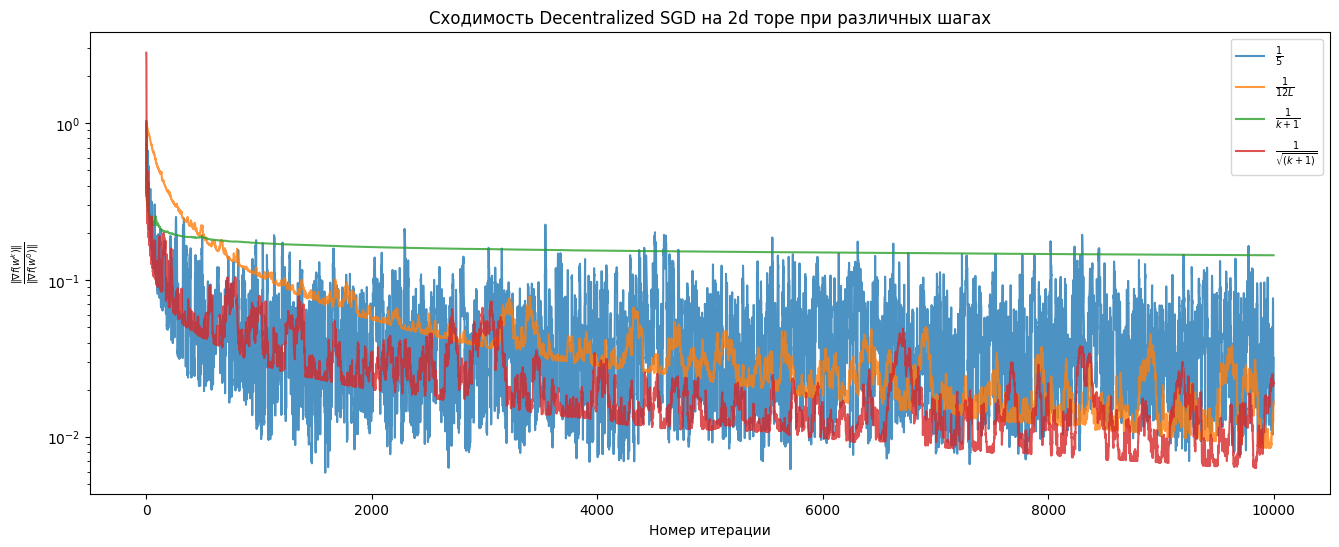

In [ ]:
gamma_labels = [r'$\frac{1}{5}$', r'$\frac{1}{12L}$', r'$\frac{1}{k + 1}$', r'$\frac{1}{\sqrt{(k + 1)}}$']
plt.figure(figsize=(16, 6))
for i in range(len(errors_w)):
    plt.plot(errors_w[i][0], errors_w[i][1], label=gamma_labels[i], alpha=0.8)
plt.title('Сходимость Decentralized SGD на 2d торе при различных шагах')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
# picking best learning rates
b = 1000
L = get_L(X_train)
L_hat = L
x_0 = np.zeros(X_train.shape[1])

n = int((len(X_train) - 1) / b + 1)
gamma_ks = [gamma_k_2]

# gamma_ks = [gamma_k_const(1/L_hat), gamma_k_const(1/L_hat/10), gamma_k_const(1/L_hat/100), gamma_k_const(1/L_hat*10),gamma_k_1, gamma_k_2]
Ws = [W_centralized(n), W_ring(n), W_torus(n)]
labels = ['Centralized', 'Ring', 'Torus']
labels_gammas = ['k_2']
best_params = []
errors_ws = []
accuracies_ws = []
for i in range(len(Ws)):
    errors_ws.append([])
    accuracies_ws.append([])
    for j in range(len(gamma_ks)):
        w_star, errors = DSGD_correct(x_0, X_train, y_train, empirical_risk, Ws[i], b, gamma_ks[j])
        errors_ws[i].append(errors)
        accuracies_ws[i].append(get_accuracies(errors[2], X_test, y_test))

7 929 928


100%|██████████| 10000/10000 [01:50<00:00, 90.37it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


110.69863033294678
10000
0.9858461538461538
7 929 928


100%|██████████| 10000/10000 [01:53<00:00, 88.19it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


113.4568305015564
10000
0.9858461538461538
7 929 928


100%|██████████| 10000/10000 [01:50<00:00, 90.58it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


110.44660592079163
10000
0.9876923076923076


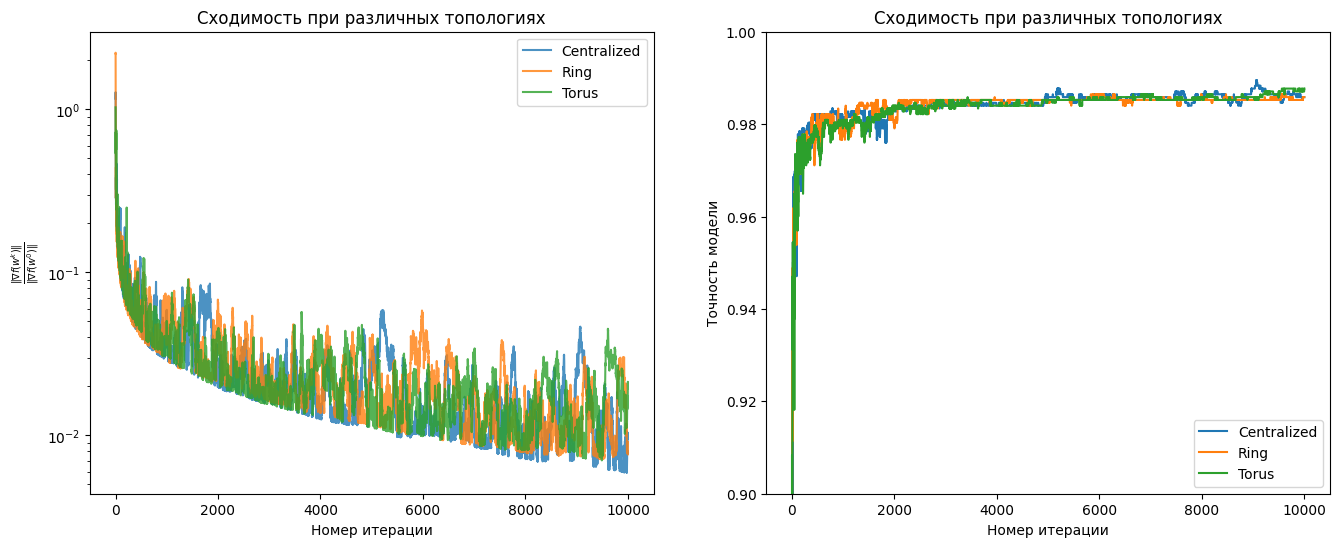

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for i in range(len(errors_ws)):
    plt.plot(errors_ws[i][0][0], errors_ws[i][0][1], label=labels[i], alpha=0.8)
plt.title('Сходимость при различных топологиях')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.subplot(1, 2, 2)
for i in range(len(accuracies_ws)):
    plt.plot(accuracies_ws[i][0][0], accuracies_ws[i][0][1], label=labels[i])
plt.title('Сходимость при различных топологиях')
plt.xlabel('Номер итерации')
plt.ylabel('Точность модели')
plt.ylim(0.9, 1)
#plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# picking best steps for local sgd
b = 1000
L = get_L(X_train)
L_hat = L
x_0 = np.zeros(X_train.shape[1])

n = int((len(X_train) - 1) / b + 1)
ks = [1, 4, 16, 64, 256]
errors_ws = []
accuracies_ws = []
for i in range(len(ks)):
    w_star, errors = DSGD_correct(x_0, X_train, y_train, empirical_risk, W_local(n, ks[i], W_torus(n)), b, gamma_k_const(1/get_L(X_train)/12), 1000)
    errors_ws.append(errors)
    accuracies_ws.append(get_accuracies(errors[2], X_test, y_test))

7 929 928


100%|██████████| 1000/1000 [00:14<00:00, 70.59it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


14.232324361801147
1000
0.9698461538461538
7 929 928


100%|██████████| 1000/1000 [00:11<00:00, 85.47it/s] 
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


11.741174936294556
1000
0.9729230769230769
7 929 928


100%|██████████| 1000/1000 [00:11<00:00, 84.40it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


11.882887840270996
1000
0.9753846153846154
7 929 928


100%|██████████| 1000/1000 [00:09<00:00, 110.89it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


9.060978412628174
1000
0.9667692307692307
7 929 928


100%|██████████| 1000/1000 [00:11<00:00, 85.40it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


11.77765154838562
1000
0.9556923076923077


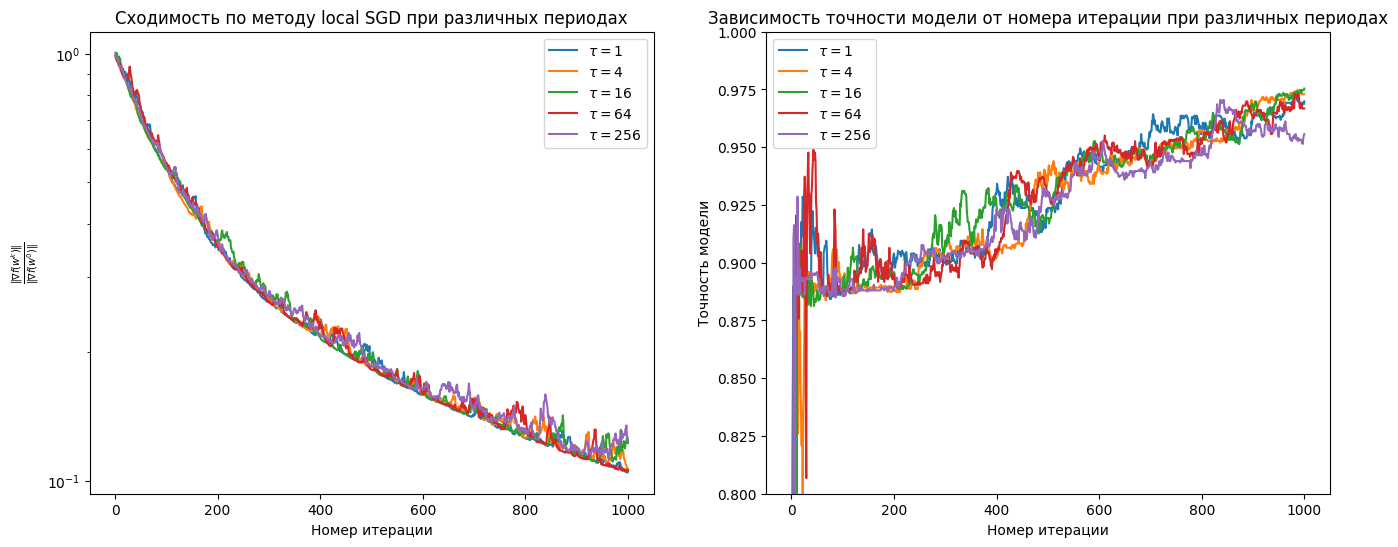

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for i in range(len(ks)):
    plt.plot(errors_ws[i][0], errors_ws[i][1], label=r'$\tau = $' + str(ks[i]))
plt.title('Сходимость по методу local SGD при различных периодах')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.subplot(1, 2, 2)
for i in range(len(accuracies_ws)):
    plt.plot(accuracies_ws[i][0], accuracies_ws[i][1], label=r'$\tau = $' + str(ks[i]))
plt.title('Зависимость точности модели от номера итерации при различных периодах')
plt.xlabel('Номер итерации')
plt.ylabel('Точность модели')
plt.ylim(0.8, 1)
#plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
print(b, n)

100 65


In [ ]:
b= 1000
print(len(X_train), n, b)
n = int((len(X_train) - 1) / b + 1)
zetas = []
print(n)
for i in range(n):
    nabla = np.mean([ad.grad(empirical_risk(X_train[i], y_train[i], get_L_v(X_train[i])))(w_star) for j in range(b * i, min(len(X_train), b * (i + 1)))])
    zetas.append(norm(nabla) ** 2)
    print(zetas[-1])
nablas = [norm(ad.grad(empirical_risk(X_train[i], y_train[i], get_L_v(X_train[i])))(w_star)) ** 2 for i in range(len(X_train))]
print('Diversity of functions:', np.mean(zetas))

6499 7 1000
7
8.264396022153709e-05
0.0001420512408880773
1.0138426714425318e-07
0.0009312732227161225


KeyboardInterrupt: ignored

In [ ]:
print(len(X_train), n, b)
n = int((len(X_train) - 1) / b + 1)
sigmas = []
for i in range(n):
    grads = [ad.grad(empirical_risk(X_train[i], y_train[i], get_L_v(X_train[i])))(w_star) for j in range(b * i, min(len(X_train), b * (i + 1)))]
    nabla = np.mean(grads, axis=0)
    sigmas.append(np.mean([norm(grads[i] - nabla)**2 for i in range(len(grads))]))
    print(sigmas[-1])
print(np.mean(sigmas))

6499 7 1000
1.8558333950742885e-26
1.8887620063725733e-26
1.5778600038160306e-26
2.3636887075870048e-26
2.0722238912962337e-26
2.7216680856236646e-26
4.627518581137231e-27
1.8489697068405028e-26


In [ ]:
print('Diversity of functions:', np.mean(zetas))
print('Noise level:', np.mean(sigmas))

Diversity of functions: 0.0004812520358598283
Noise level: 1.8489697068405028e-26


In [ ]:
b = 1000
L = get_L(X_train)
L_hat = L
x_0 = np.ones(X_train.shape[1])
n = int((len(X_train) - 1) / b + 1)
Ws = [W_full(n)]
labels = ['full']
errors_ws = []
accuracies_ws = []
for i in range(len(Ws)):
    w_star, errors = DSGD_correct(x_0, X_train, y_train, empirical_risk, Ws[i], b, gamma_k_2, 1000)
    errors_ws.append(errors)
    accuracies_ws.append(get_accuracies(errors[2], X_test, y_test))

In [ ]:
print(get_accuracies([w_star], X_test, y_test))

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for i in range(len(errors_ws)):
    plt.plot(errors_ws[i][0], errors_ws[i][1], label=labels[i])
plt.title('Сходимость по методу DSGD')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.subplot(1, 2, 2)
for i in range(len(accuracies_ws)):
    plt.plot(accuracies_ws[i][0], accuracies_ws[i][1], label=labels[i])
plt.title('Зависимость точности модели от номера итерации')
plt.xlabel('Номер итерации')
plt.ylabel('Точность модели')
plt.ylim(0.8, 1)
#plt.yscale('log')
plt.legend()
plt.show()